# Imports

In [1]:
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.data import AUTOTUNE
from tensorflow.keras.models import Model
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger, TensorBoard
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPool2D, UpSampling2D, SpatialDropout2D, BatchNormalization, ReLU, Concatenate, Add

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ResUnet Autoencoder - CelebA

Visualizar o encoding e decoding de rostos humanos, usando um autoencoder U-net + Residual blocks e o dataset CelebA (+200.000 amostras) \
Dataset disponível em: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset

In [ ]:
# Carregamento do dataset via arquivo zip
caminho_arquivo = '/content/drive/MyDrive/projetos/celebA_autoencoders/CelebA_images.zip'
pasta_destino = '/content/CelebA_dataset'

with zipfile.ZipFile(caminho_arquivo, 'r') as z:
  z.extractall(pasta_destino)

In [ ]:
# Divisão em base de treino e validação
full_train = image_dataset_from_directory(
    directory='/content/CelebA_dataset',
    label_mode=None,
    validation_split=0.1,
    subset='training',
    batch_size=32,
    image_size=(176, 216),
    seed=111,
    shuffle=False
)

val_ds = image_dataset_from_directory(
    directory='/content/CelebA_dataset',
    label_mode=None,
    validation_split=0.1,
    subset='validation',
    batch_size=32,
    image_size=(176, 216),
    seed=111,
    shuffle=False
)

# Pegando parte do treino como teste
test_size = 0.2
test_ds = full_train.take(int(len(full_train) * test_size))
train_ds = full_train.skip(int(len(full_train) * test_size))

# Treino -> 72%
# Teste  -> 18%
# Val    -> 10%

Found 202599 files.
Using 182340 files for training.
Found 202599 files.
Using 20259 files for validation.


In [ ]:
print('- ' * 10)
print(f'{int(len(train_ds) * 8)} - {int(len(train_ds) * 8) / 202599:.2%}')
print(f'{int(len(test_ds) * 8)} - {int(len(test_ds) * 8) / 202599:.2%}')
print(f'{int(len(val_ds) * 8)} - {int(len(val_ds) * 8) / 202599:.2%}')

- - - - - - - - - - 
36480 - 18.01%
9112 - 4.50%
5072 - 2.50%


## Normalização dos valores

In [ ]:
def normaliza_ds(image):
  image = tf.cast(image, tf.float32) / 255
  return image

train_ds = train_ds.map(normaliza_ds, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.prefetch(AUTOTUNE)

test_ds = test_ds.map(normaliza_ds, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

val_ds = val_ds.map(normaliza_ds, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

In [ ]:
print(next(iter(train_ds.take(1))).shape)
print(next(iter(test_ds.take(1))).shape)
print(next(iter(val_ds.take(1))).shape)

(32, 176, 216, 3)
(32, 176, 216, 3)
(32, 176, 216, 3)


In [ ]:
train_ds = train_ds.map(lambda x: (x, x))
test_ds = test_ds.map(lambda x: (x, x))
val_ds = val_ds.map(lambda x: (x, x))

## Blocos residuais (ResBlock)

In [ ]:
def residual_block(x_in, filters, kernel_size=(3,3)):
  shortcut = x_in

  # 1a Conv
  x = Conv2D(filters, kernel_size, padding='same', use_bias=False)(x_in)
  x = BatchNormalization()(x)
  x = ReLU()(x)

  # 2a Conv
  x = Conv2D(filters, kernel_size, padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)

  x = Add()([x, shortcut])
  x = ReLU()(x)

  return x

## Definição do ResUnet Autoencoder

In [ ]:
def resUnet_autoencoder(input_shape=(176, 216, 3), kernel_size=(3,3), base_filters=32):
  # Entrada
  inp = Input(shape=input_shape)

  # --- Encoder ---
  enc1 = Conv2D(base_filters, kernel_size, padding='same', use_bias=False)(inp)
  enc1 = BatchNormalization()(enc1)
  enc1 = ReLU()(enc1)
  enc1 = residual_block(enc1, base_filters)
  pool1 = MaxPool2D()(enc1)

  enc2 = Conv2D(base_filters*2, kernel_size, padding='same', use_bias=False)(pool1)
  enc2 = BatchNormalization()(enc2)
  enc2 = ReLU()(enc2)
  enc2 = residual_block(enc2, base_filters*2)
  pool2 = MaxPool2D()(enc2)

  enc3 = Conv2D(base_filters*4, kernel_size, padding='same', use_bias=False)(pool2)
  enc3 = BatchNormalization()(enc3)
  enc3 = ReLU()(enc3)
  enc3 = residual_block(enc3, base_filters*4)
  pool3 = MaxPool2D()(enc3)

  # --- Bottleneck ---
  bneck = Conv2D(base_filters*8, kernel_size, padding='same', use_bias=False)(pool3)
  bneck = BatchNormalization()(bneck)
  bneck = ReLU()(bneck)
  bneck = residual_block(bneck, base_filters*8)

  # --- Decoder ---
  dec3 = UpSampling2D()(bneck)
  dec3 = Concatenate()([dec3, enc3]) # <- Skip connection
  dec3 = Conv2D(base_filters*4, kernel_size, padding='same', use_bias=False)(dec3)
  dec3 = BatchNormalization()(dec3)
  dec3 = ReLU()(dec3)
  dec3 = residual_block(dec3, base_filters*4)

  dec2 = UpSampling2D()(dec3)
  dec2 = Concatenate()([dec2, enc2]) # <- Skip connection
  dec2 = Conv2D(base_filters*2, kernel_size, padding='same', use_bias=False)(dec2)
  dec2 = BatchNormalization()(dec2)
  dec2 = ReLU()(dec2)
  dec2 = residual_block(dec2, base_filters*2)

  dec1 = UpSampling2D()(dec2)
  dec1 = Concatenate()([dec1, enc1]) # <- Skip connection
  dec1 = Conv2D(base_filters, kernel_size, padding='same', use_bias=False)(dec1)
  dec1 = BatchNormalization()(dec1)
  dec1 = ReLU()(dec1)
  dec1 = residual_block(dec1, base_filters)

  # Saída
  out = Conv2D(3, (1,1), activation='sigmoid')(dec1)

  return Model(inputs=inp, outputs=out)

In [ ]:
resUnet_autoencoder = resUnet_autoencoder(input_shape=(176, 216, 3),
                                          kernel_size=(3,3),
                                          base_filters=8
                                          )

In [ ]:
resUnet_autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 176, 216,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 176, 216,  │        216 │ input_layer[0][0] │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 176, 216,  │         32 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 176, 216,  │          0 │ batch_normalizat… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 176, 216,  │        576 │ re_lu[0][0]       │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 176, 216,  │         32 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 176, 216,  │          0 │ batch_normalizat… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 176, 216,  │        576 │ re_lu_1[0][0]     │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 176, 216,  │         32 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 176, 216,  │          0 │ batch_normalizat… │
│                     │ 8)                │            │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 176, 216,  │          0 │ add[0][0]         │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 88, 108,   │          0 │ re_lu_2[0][0]     │
│ (MaxPooling2D)      │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 88, 108,   │      1,152 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 88, 108,   │         64 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 88, 108,   │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 88, 108,   │      2,304 │ re_lu_3[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 88, 108,   │         64 │ conv2d_4[0][0]  

 Total params: 184,947 (722.45 KB)

 Trainable params: 183,891 (718.32 KB)

 Non-trainable params: 1,056 (4.12 KB)

In [ ]:
for i, layer in enumerate(resUnet_autoencoder.layers):
    print(i, layer.name)

0 input_layer
1 conv2d
2 batch_normalization
3 re_lu
4 conv2d_1
5 batch_normalization_1
6 re_lu_1
7 conv2d_2
8 batch_normalization_2
9 add
10 re_lu_2
11 max_pooling2d
12 conv2d_3
13 batch_normalization_3
14 re_lu_3
15 conv2d_4
16 batch_normalization_4
17 re_lu_4
18 conv2d_5
19 batch_normalization_5
20 add_1
21 re_lu_5
22 max_pooling2d_1
23 conv2d_6
24 batch_normalization_6
25 re_lu_6
26 conv2d_7
27 batch_normalization_7
28 re_lu_7
29 conv2d_8
30 batch_normalization_8
31 add_2
32 re_lu_8
33 max_pooling2d_2
34 conv2d_9
35 batch_normalization_9
36 re_lu_9
37 conv2d_10
38 batch_normalization_10
39 re_lu_10
40 conv2d_11
41 batch_normalization_11
42 add_3
43 re_lu_11
44 up_sampling2d
45 concatenate
46 conv2d_12
47 batch_normalization_12
48 re_lu_12
49 conv2d_13
50 batch_normalization_13
51 re_lu_13
52 conv2d_14
53 batch_normalization_14
54 add_4
55 re_lu_14
56 up_sampling2d_1
57 concatenate_1
58 conv2d_15
59 batch_normalization_15
60 re_lu_15
61 conv2d_16
62 batch_normalization_16
63 re_lu_1

## Loss MSE + SSIM + Charbonnier

In [9]:
def mse_ssim_charb_loss(y_true, y_pred):
  mse = tf.reduce_mean(tf.square(y_true - y_pred))
  ssim = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.))
  charbonnier = tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3)))
  return .5*mse + .3*ssim + .2*charbonnier

In [ ]:
resUnet_autoencoder.compile(optimizer='adam', loss=mse_ssim_charb_loss)

## Treinamento do autoencoder

In [ ]:
history = resUnet_autoencoder.fit(train_ds,
                                  validation_data=val_ds,
                                  epochs=5,
                                  callbacks=[
                                      ModelCheckpoint('best_resUnet.keras', monitor='val_loss', save_best_only=True, save_weights_only=False, verbose=1),
                                      EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
                                      ReduceLROnPlateau(monitor='val_loss', factor=.5, patience=3, verbose=0),
                                  ])

Epoch 1/5
4560/4560 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0315
Epoch 1: val_loss improved from inf to 0.01319, saving model to best_resUnet.keras
4560/4560 ━━━━━━━━━━━━━━━━━━━━ 698s 142ms/step - loss: 0.0315 - val_loss: 0.0132 - learning_rate: 0.0010
Epoch 2/5
4559/4560 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0077
Epoch 2: val_loss improved from 0.01319 to 0.00712, saving model to best_resUnet.keras
4560/4560 ━━━━━━━━━━━━━━━━━━━━ 651s 139ms/step - loss: 0.0077 - val_loss: 0.0071 - learning_rate: 0.0010
Epoch 3/5
4559/4560 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0054
Epoch 3: val_loss improved from 0.00712 to 0.00423, saving model to best_resUnet.keras
4560/4560 ━━━━━━━━━━━━━━━━━━━━ 700s 143ms/step - loss: 0.0054 - val_loss: 0.0042 - learning_rate: 0.0010
Epoch 4/5
4559/4560 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0044
Epoch 4: val_loss improved from 0.00423 to 0.00410, saving model to best_resUnet.keras
4560/4560 ━━━━━━━━━━━━━━━━━━━━ 663s 139ms/step - loss: 0.0044

## Salvamento e carregamento do AE

In [ ]:
resUnet_autoencoder.save('resUnet_autoencoder_8filters.keras')

In [10]:
resUnet_autoencoder = tf.keras.models.load_model('/content/drive/MyDrive/projetos/celebA_autoencoders/resUnet_autoencoder/resUnet_autoencoder.keras', custom_objects={"mse_ssim_charb_loss": mse_ssim_charb_loss})

## Definição do encoder

In [ ]:
encoder = Model(inputs=resUnet_autoencoder.input,
                outputs=resUnet_autoencoder.layers[43].output
               )

## Gráficos e visualização

In [ ]:
fixed_samples = np.load('/content/drive/MyDrive/projetos/celebA_autoencoders/fixed_samples.npy')

fixed_samples = tf.reshape(fixed_samples, (-1, 178, 218, 3)) # (10, 178, 218, 3)
fixed_samples = tf.image.resize(fixed_samples, (176, 216)) # (10, 176, 216, 3)
fixed_samples = tf.reshape(fixed_samples, (5, 2, 176, 216, 3)).numpy() # (5, 2, 7452)

In [ ]:
fixed_samples.shape

(5, 2, 176, 216, 3)

In [ ]:
sample = fixed_samples[0,0]
print("sample dtype/min/max/mean:", sample.dtype, sample.min(), sample.max(), sample.mean())

img = sample.astype('float32')
if img.max() > 1.0:
    img = img / 255.0
print("after scaling min/max/mean:", img.min(), img.max(), img.mean())

pred = resUnet_autoencoder.predict(np.expand_dims(img, axis=0), verbose=False)[0]
print("pred dtype/min/max/mean:", pred.dtype, pred.min(), pred.max(), pred.mean())

sample dtype/min/max/mean: float32 0.0 1.0 0.58677167
after scaling min/max/mean: 0.0 1.0 0.58677167
pred dtype/min/max/mean: float32 0.001564482 0.9929813 0.58345926


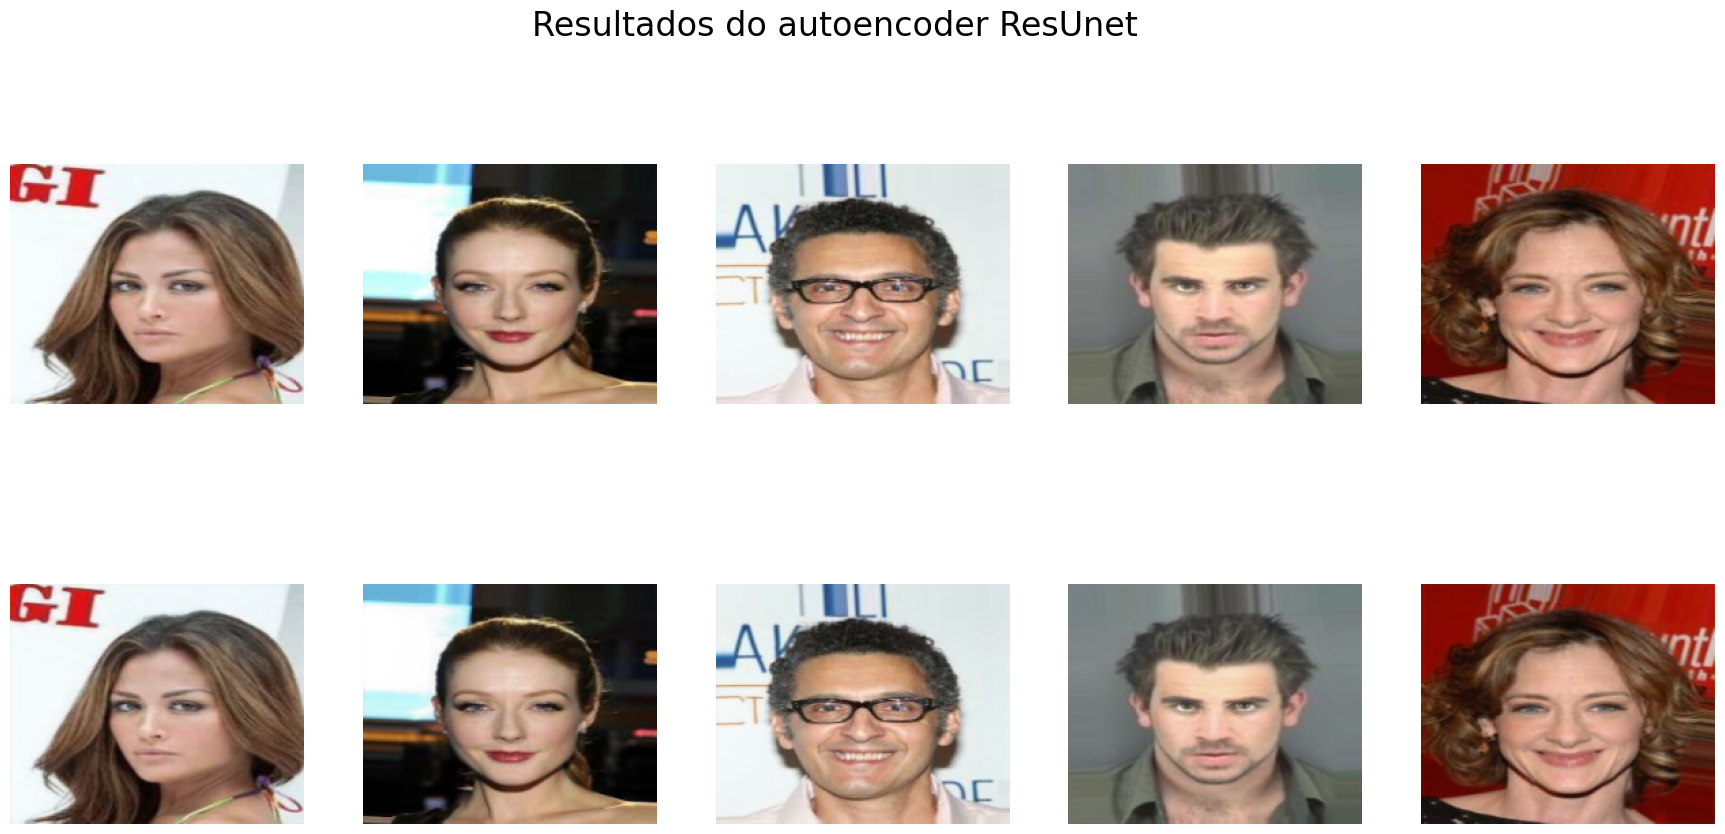

In [ ]:
samples = fixed_samples

plt.figure(figsize=(22, 10))
for i, (im, _) in enumerate(samples):
  im = tf.expand_dims(im, axis=0)
  decoded = resUnet_autoencoder.predict(im, verbose=False)

  plt.suptitle('Resultados do autoencoder ResUnet', fontsize=24)

  plt.subplot(2, 5, i+1)
  plt.imshow(tf.reshape(im, (176, 216, 3)))
  plt.axis('off')

  plt.subplot(2, 5, i+6)
  plt.imshow(tf.reshape(decoded, (176, 216, 3)))
  plt.axis('off')

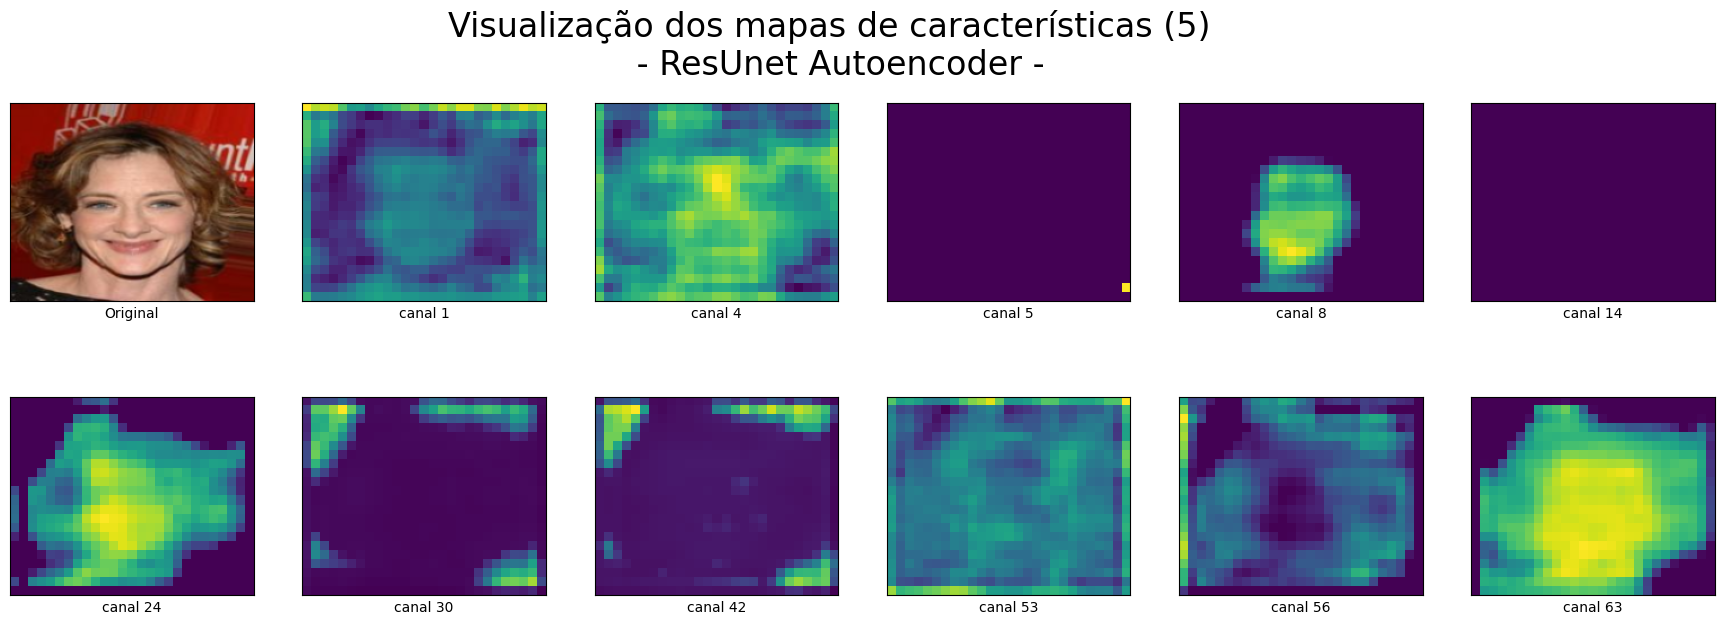

In [ ]:
sample = fixed_samples[4]

original = tf.reshape(sample[0], (176, 216, 3))

latent = encoder.predict(sample, verbose=False)[0] # Mapa de características
canais = [1,  4,  5,  8,  14, 24,
          30, 42, 53, 56, 63]

plt.figure(figsize=(22, 7))

# Imagem original
plt.suptitle('Visualização dos mapas de características (5) \n - ResUnet Autoencoder -', fontsize=24)
plt.subplot(2, 6, 1)
plt.imshow(original)
plt.xlabel(f'Original')
plt.xticks(())
plt.yticks(())

# Canais
for i, c in enumerate(canais):
  plt.subplot(2, 6, i+2)
  plt.imshow(latent[:, :, c].reshape(22, 27), cmap='viridis')
  plt.xlabel(f'canal {c}')
  plt.xticks(())
  plt.yticks(())

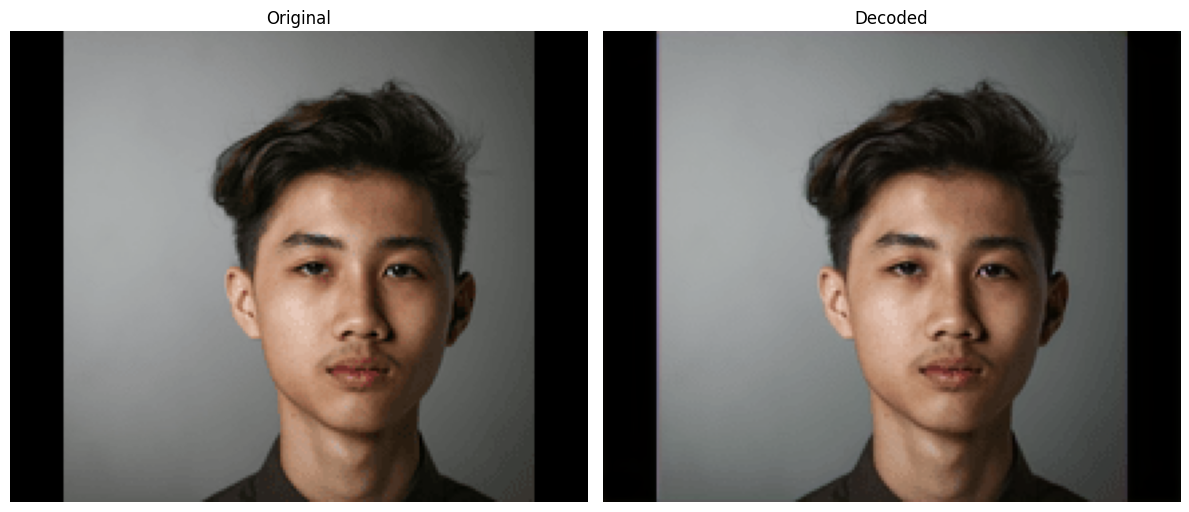

In [18]:
img = plt.imread('/content/drive/MyDrive/projetos/celebA_autoencoders/test.png')[:, :, :3]
img = tf.image.resize(img, (176, 216))
img = tf.expand_dims(img, axis=0)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(tf.reshape(img, (176, 216, 3)))
plt.title('Original')
plt.axis('off');

plt.subplot(1, 2, 2)
plt.imshow(tf.reshape(resUnet_autoencoder.predict(img, verbose=False), (176, 216, 3)))
plt.title('Decoded')
plt.axis('off');

plt.tight_layout()

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

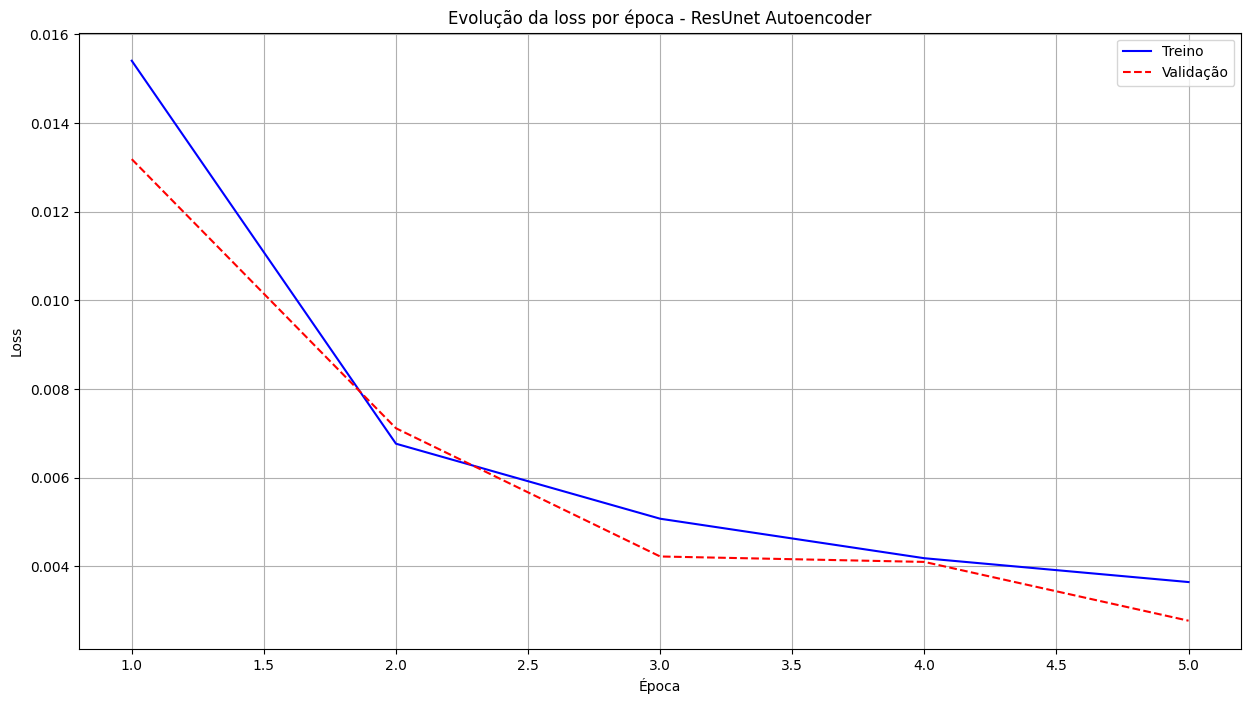

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(epochs, loss, 'b-', label='Treino')
plt.plot(epochs, val_loss, 'r--', label='Validação')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Evolução da loss por época - ResUnet Autoencoder')
plt.legend()
plt.grid(True)
plt.show();